In [18]:
from os import listdir
import numpy as np
import pandas as pd
import nslr_hmm
from my_utils.gaze import split_events, pixels2angles, get_fixndur, angle_between_first_and_last_points

In [2]:
def load_reutter(path):
    scanpath = []
    for subject in sorted(listdir(path)):
        # read the whole file into variable `events` (list with one entry per line)
        with open(path + subject) as f:
            events = f.readlines()

        events = [event for event in events if 'SFIX' and 'SSACC' and 'MSG' and 'ESACC' not in event]
        trial_start_indices = np.where(["START" in ev for ev in events])[0]

        sub_scan = []
        for i in range(len(trial_start_indices) - 1):  # for each trial
            current_trial = events[trial_start_indices[i] + 7: trial_start_indices[i + 1] - 9]  # Removing starting and ending info
            trial_coor = []
            for event in current_trial:
                if 'EFIX' not in event:
                    try:
                        x = float(event.split('\t')[1])
                        y = float(event.split('\t')[2])
                        trial_coor.append([x, y])
                    except:
                        pass
                else:
                    x = float(event.split('\t')[4])  # in case of fixation end x and y coordinates are in positions 4,5
                    y = float(event.split('\t')[5])
                    trial_coor.append([x, y])
            trial_coor = np.asarray(trial_coor)
            sub_scan.append(trial_coor)
        sub_scan = np.asarray(sub_scan)
        scanpath.append(sub_scan)
    parameters = {
        'distance': 0.53,
        'width': 0.531, #check
        'height': 0.298, #check
        'x_res': 1920, #check
        'y_res': 1080, #check
        'fs': 1000.}
    scanpath = np.asarray(scanpath)
    return scanpath, parameters

In [3]:
data_reutter = load_reutter('./datasets/Reutter/')

C:\Users\vince\AppData\Local\Temp\ipykernel_23192\2467140901.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sub_scan = np.asarray(sub_scan)


In [15]:
distance = 0.53
width = 0.531
height = 0.298
x_res = 1920
y_res = 1080
fs = 1000.0

In [151]:
gaze_data = data_reutter[0][0][87]
parameters = data_reutter[1]

In [158]:
n_samples = gaze_data.shape[0]
dur = n_samples / fs
t = np.linspace(0., dur, n_samples)
gaze_data_ang = pixels2angles(gaze_data, parameters['distance'], parameters['width'],
                parameters['height'], parameters['x_res'], parameters['y_res'])
print('\nStarting NSLR Classification...')
sample_class, segmentation, seg_class = nslr_hmm.classify_gaze(t, gaze_data_ang)
print('...done. Starting CBW Estimation!')
fixations = sample_class == nslr_hmm.FIXATION
sp = sample_class == nslr_hmm.SMOOTH_PURSUIT
saccades = sample_class == nslr_hmm.SACCADE
pso = sample_class == nslr_hmm.PSO
fix = np.logical_or(fixations, sp).astype(bool)  # merge fixations and smooth pursuits
sac = np.logical_or(saccades, pso).astype(bool) # merge saccades and pso
all_fix = split_events(gaze_data, fix)
all_sac = split_events(gaze_data, sac)


Starting NSLR Classification...
	Starting Segmentation...
	Classifying Segments...
...done. Starting CBW Estimation!


In [196]:
#Computing mean of fixational events
fixations_means = [(all_fix[i].mean(0), len(all_fix[i])) for i in range(len(all_fix))]

#Picking starting and ending points of each saccade
sacc = [(xy[0], xy[-1]) for xy in all_sac]
x_sac = []
y_sac = []

for sac in sacc:
    x_sac.append(sac[0][0])
    x_sac.append(sac[1][0])
    y_sac.append(sac[0][1])
    y_sac.append(sac[1][1])

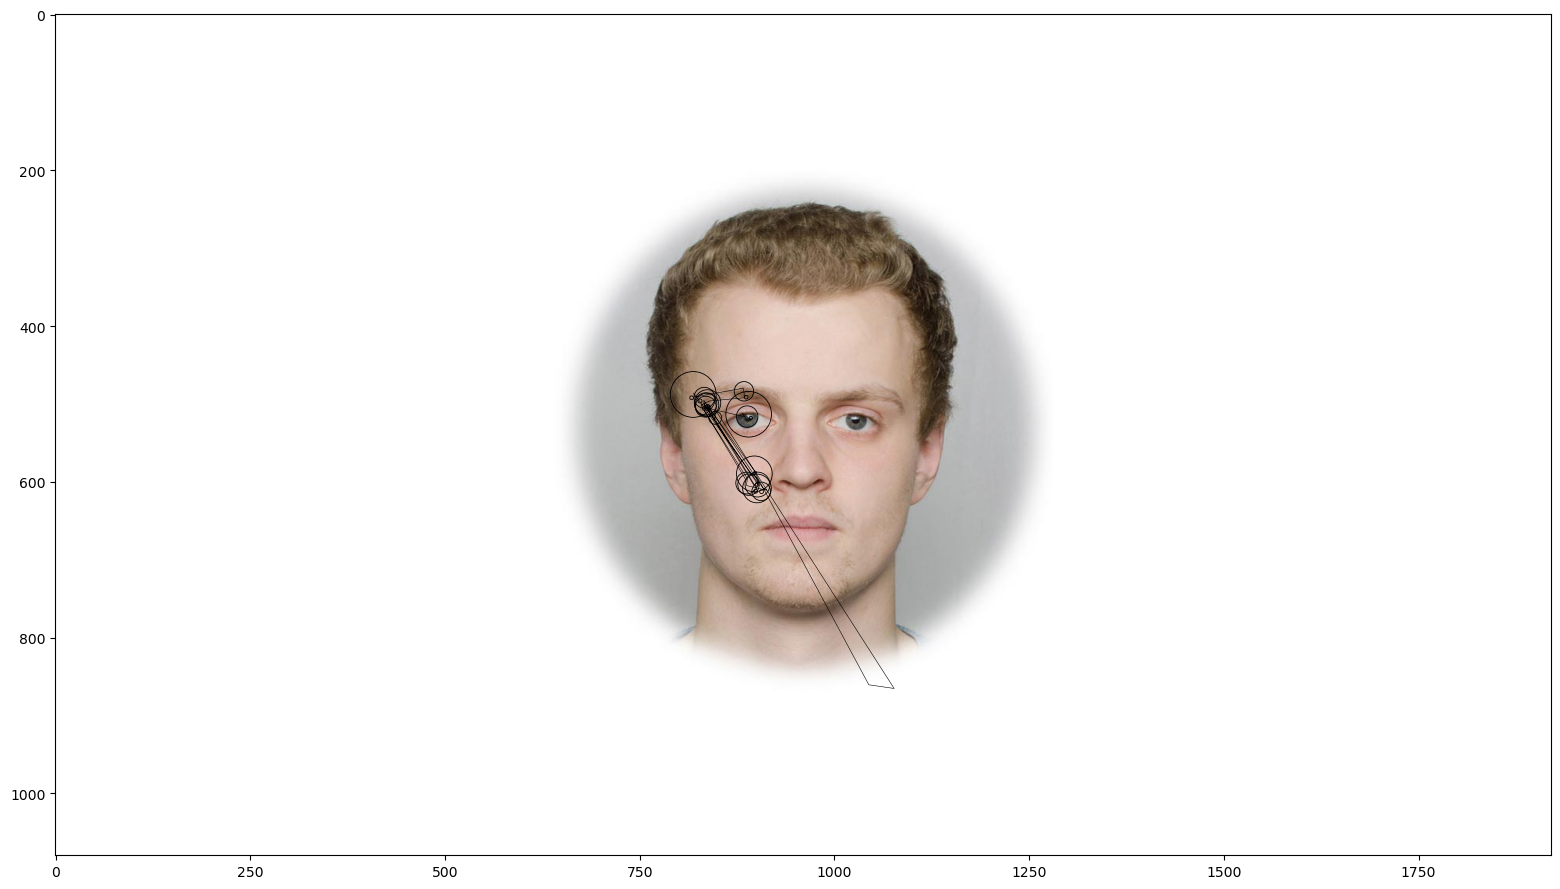

In [216]:
from matplotlib import pyplot as plt

#plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["figure.autolayout"] = True
im = plt.imread("scanpath_bg.jpg")
fig, ax = plt.subplots()

x_fix = [f[0][0] for f in fixations_means]
y_fix = [f[0][1] for f in fixations_means]
sizes = [f[1] for f in fixations_means]

ax.scatter(x_fix, y_fix, s=sizes, facecolors='none', color='black', linewidth=0.6)

ax.plot(x_sac, y_sac, linewidth=0.4, color='black')
im = ax.imshow(im)
plt.show()

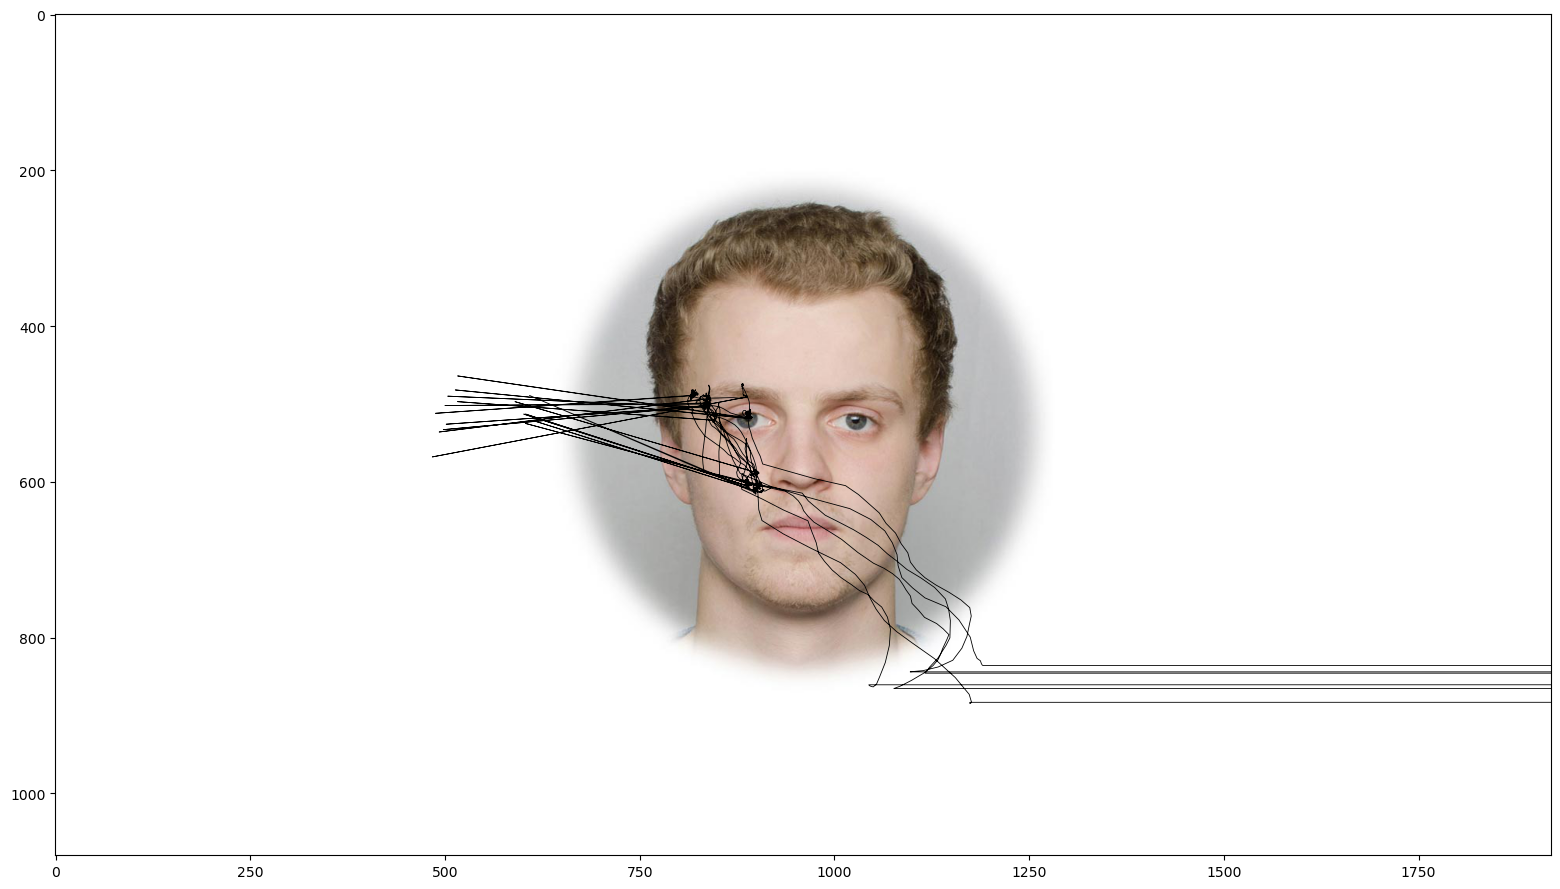

In [217]:
from matplotlib import pyplot as plt

plt.rcParams["figure.autolayout"] = True
im = plt.imread("scanpath_bg.jpg")
fig, ax = plt.subplots()

x = data_reutter[0][0][87][:,0]
y = data_reutter[0][0][87][:,1]
ax.plot(x, y, linewidth=0.6, color='black')
im = ax.imshow(im)
plt.show()